In [1]:
# =====================================================================================
#  BLOQUE DE LIMPIEZA - EJECUTAR SIEMPRE PRIMERO PARA EVITAR BUG DE CNN (KERNEL SUCIO)
# =====================================================================================

import gc
import tensorflow as tf
from tensorflow import keras

# 1. Limpiar sesión de Keras
keras.backend.clear_session()

# 2. Resetear grafos de TensorFlow
tf.compat.v1.reset_default_graph()

# 3. Liberar memoria GPU (si tienes)
try:
    from numba import cuda
    cuda.select_device(0)
    cuda.close()
except:
    pass

# 4. Forzar recolección de basura
gc.collect()

# 5. NO ELIMINAR EL CACHE!!!

print("Kernel limpiado - listo para entrenar")

c:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):



Kernel limpiado - listo para entrenar


In [3]:
# IMPORTACIONES Y CONFIGURACIÓN DE REPRODUCIBILIDAD
# =================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import os

np.random.seed(29)
tf.random.set_seed(29)


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10 # CARGA DEL CONJUNTO DE DATOS CIFAR-10

(x_train, y_train), (x_test, y_test) = cifar10.load_data() # CARGA DEL CONJUNTO DE DATOS CIFAR-10



print(f'X_test shape: {x_test.shape}')
print(f'Y_test shape: {y_test.shape}')
print(f'X_train shape: {x_train.shape}')
print(f'Y_train shape: {y_train.shape}')

X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 1)
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 1)


In [5]:
# VALIDACION (recomendado en ANN/RNN/CNN)
# =======================================

x_train_final, x_val, y_train_final, y_val = train_test_split(
     x_train, y_train,
     test_size=0.2,  # 20% para validación de 5000 imagenes
     random_state=1,
     stratify=y_train)

size_Xdata = len(x_train_final)



class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] # NOMBRES DE LAS CLASES




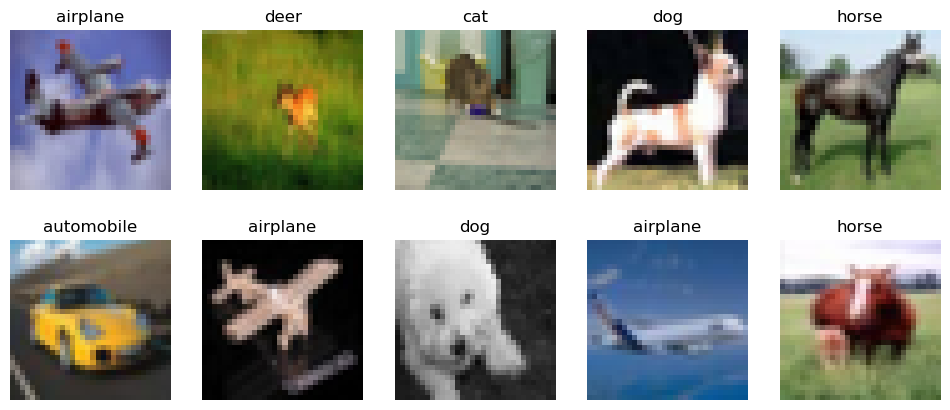

In [6]:
fig, axes = plt.subplots(2,5, figsize=(12,5)) # CREAMOS SUBPLOTS
axes = axes.flatten() # APLANAMOS PARA ITERAR MÁS FÁCILMENTE

random_list = random.sample(range(size_Xdata), 10) # ELEGIMOS 10 ÍNDICES ALEATORIOS SIN REPETICIÓN

for i,idx in enumerate(random_list):
    axes[i].imshow(x_train_final[idx] / 255.0)
    label = y_train_final[idx].item()
    axes[i].set_title(f'{class_names[(label)]}') # CONVERTIMOS EN INT A Y_TRAIN PARA USARLO COMO ÍNDICE
    axes[i].axis('off')

plt.show()

In [7]:
#TRAIN DATASET PIPELINE

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = (128, 128)
BATCH_SIZE = 64


train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train_final, y_train_final)
)

train_ds = train_ds.map(
    lambda x, y: (tf.image.resize(x, IMG_SIZE), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
#VALIDACION DATASET PIPELINE

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

val_ds = val_ds.map(
    lambda x, y: (tf.image.resize(x, IMG_SIZE), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

val_ds = val_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
# TESTEo DATASET PIPELINE

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

test_ds = test_ds.map(
    lambda x, y: (tf.image.resize(x, IMG_SIZE), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_ds = test_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_ds = test_ds.batch(BATCH_SIZE)

In [10]:
# ==================================
#  MODELO BASE - FEATURE EXTRACTION
# ==================================

base_model = MobileNetV2(
    input_shape=(128,128,3),    # Capa de entrada del modelo: input imágenes = Backbone = Conv + Pool
    include_top = False,      # No me incluyas otra cosa que las imágenes (Dense ANN = False) No traer capas Dense ANN
    weights = 'imagenet')     # Pesos usados de esas imágenes de imagenet
                              # Importancia de las variables dada por el algoritmo a distintas neuronas de la capa anterior)

base_model.trainable = False  # Congelar! Ya está entrenado. Si se vuelve a entrenar se obtiene otro modelo diferente.


In [11]:
# ===========================
#  ARQUITECTURA DE MI MODELO
# ===========================

# La dificultad está en elegir el proceso correcto o adecuado a nuestro problema.

model = Sequential()

model.add(Input(shape=(128,128,3)))   # Entran imagenes (CNN) - Resolución de imagen + color: 32x32

model.add(base_model)               # Convolucional + Pooling + Dropout (x 150 veces o capas en MobileNetV2)

model.add(GlobalAveragePooling2D()) # Flatten (aplanamiento tomando el promedio global)

model.add(Dense(64, activation='relu')) # 64 neuronas (tamaño mediano-pequeño) # Blackbone fuerte ==> Dense liviana
model.add(Dropout(0.4))  # Grande

model.add(Dense(10, activation='softmax'))

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,618 (8.93 MB)

 Trainable params: 82,634 (322.79 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ======================================
#  COMPILAR 
# ======================================

model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9), # Adam es un optimizador avanzado.
    loss='sparse_categorical_crossentropy', # Función de clasificación (categorical > 2). Como es más de dos ==> no es binary_crossentropy
    metrics=['accuracy']) # Por ser de clasificació se emplea esta métrica.

early_stop=EarlyStopping(
   monitor='val_loss',        # Función pérdida de la validación.
   patience=5,                
   min_delta=0.001,
   restore_best_weights=True, # Restablecer o seleccionar los mejores pesos.
   verbose=1)


history = model.fit(
    train_ds, # Flatten y_train to (num_samples,) for sparse_categorical_crossentropy
    epochs=200, # TCL - Teorema Central del Límite
    validation_data=(val_ds),  # Use correctly processed x_val and y_val                 
    callbacks=[early_stop], # Llamada para que pare
    verbose=1)

print("Entrenado!")

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 276s 434ms/step - accuracy: 0.6040 - loss: 1.1696 - val_accuracy: 0.7989 - val_loss: 0.6091
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 270s 432ms/step - accuracy: 0.7583 - loss: 0.7263 - val_accuracy: 0.8253 - val_loss: 0.5242
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 430ms/step - accuracy: 0.7837 - loss: 0.6436 - val_accuracy: 0.8361 - val_loss: 0.4899
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 266s 425ms/step - accuracy: 0.7959 - loss: 0.6047 - val_accuracy: 0.8390 - val_loss: 0.4725
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 276s 442ms/step - accuracy: 0.8071 - loss: 0.5712 - val_accuracy: 0.8468 - val_loss: 0.4547
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 271s 434ms/step - accuracy: 0.8158 - loss: 0.5496 - val_accuracy: 0.8493 - val_loss: 0.4447
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 267s 427ms/step - accuracy: 0.8224 - loss: 0.5302 - val_accuracy: 0.8507 - val_loss: 0.4361
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 424ms/step - accuracy: 

              precision    recall  f1-score   support

    airplane       0.12      0.13      0.12      1000
  automobile       0.10      0.10      0.10      1000
        bird       0.09      0.09      0.09      1000
         cat       0.10      0.09      0.09      1000
        deer       0.11      0.12      0.11      1000
         dog       0.09      0.08      0.09      1000
        frog       0.11      0.10      0.10      1000
       horse       0.08      0.08      0.08      1000
        ship       0.11      0.11      0.11      1000
       truck       0.09      0.09      0.09      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



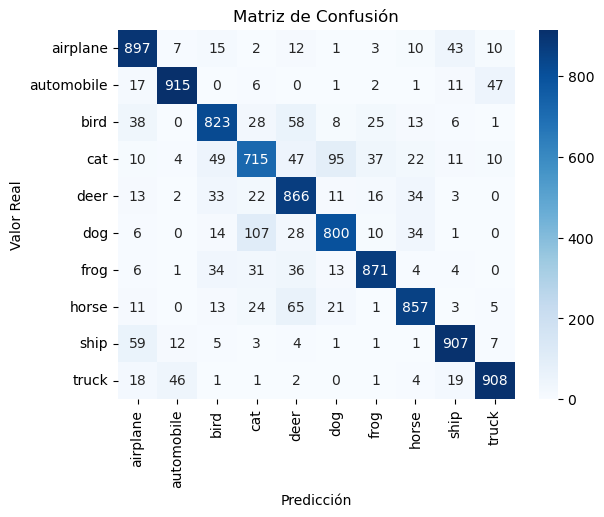

In [15]:
# Predecir probabilidades
y_pred_probs = model.predict(test_ds, verbose=0)

# Convertir a etiquetas usando argmax
y_pred = np.argmax(y_pred_probs, axis=1)

y_true_test = np.concatenate([y.numpy() for _, y in test_ds])

# Reporte de clasificación
from sklearn.metrics import classification_report
report = classification_report(y_val, y_pred, target_names=class_names)
print(report)

# =====================
#  Matriz de Confusión
# =====================

y_pred_probs = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_test = np.concatenate([y.numpy() for _, y in test_ds])

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

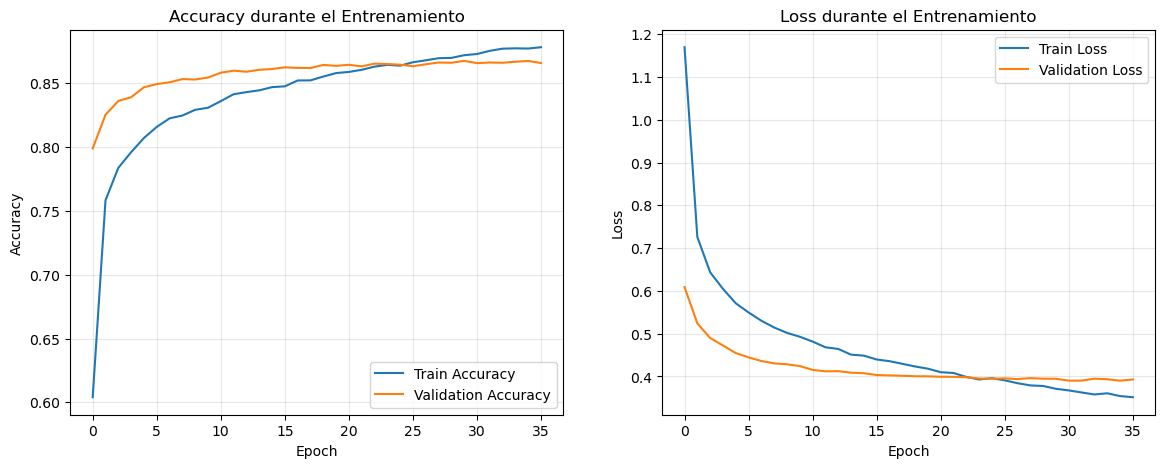

TRAIN:
Loss óptimo: 0.3542
Accuracy óptimo: 87.71%
Loss final: 0.3515
Accuracy final: 87.82%

VALIDATION:
Loss óptimo: 0.3901
Accuracy óptimo: 86.74%
Loss final: 0.3930
Accuracy final: 86.58%


In [16]:
# VISUALIZACIÓN DE CURVAS DE APRENDIZAJE
# ======================================

# Crear figura con 2 subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy durante el Entrenamiento')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss durante el Entrenamiento')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.show()

best_epoch = np.argmin(history.history['val_loss'])
print(f"TRAIN:")
print(f"Loss óptimo: {history.history['loss'][best_epoch]:.4f}")
print(f"Accuracy óptimo: {history.history['accuracy'][best_epoch]*100:.2f}%")
print(f"Loss final: {history.history['loss'][-1]:.4f}")
print(f"Accuracy final: {history.history['accuracy'][-1]*100:.2f}%")
print()
print(f"VALIDATION:")
print(f"Loss óptimo: {history.history['val_loss'][best_epoch]:.4f}")
print(f"Accuracy óptimo: {history.history['val_accuracy'][best_epoch]*100:.2f}%")
print(f"Loss final: {history.history['val_loss'][-1]:.4f}")
print(f"Accuracy final: {history.history['val_accuracy'][-1]*100:.2f}%")

157/157 ━━━━━━━━━━━━━━━━━━━━ 62s 384ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8726716..0.98026955].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.921201].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70637256..0.8259804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93235296..0.7019608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98039216..0.64215684].


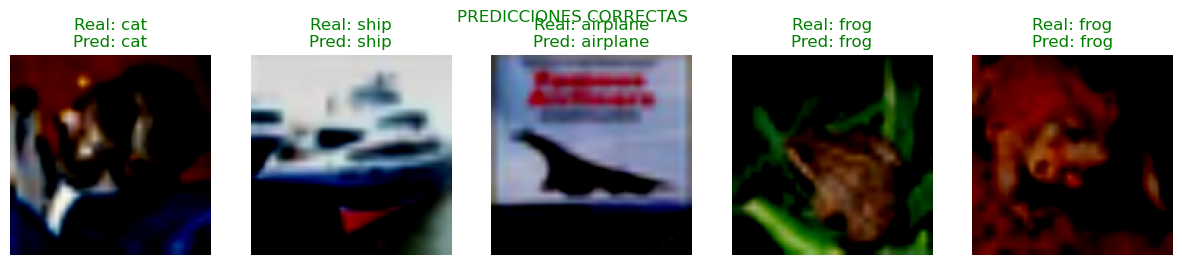

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9759804..0.9675245].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77340686..0.67499995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8208333..0.8311274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90821075].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9431372..0.8561275].


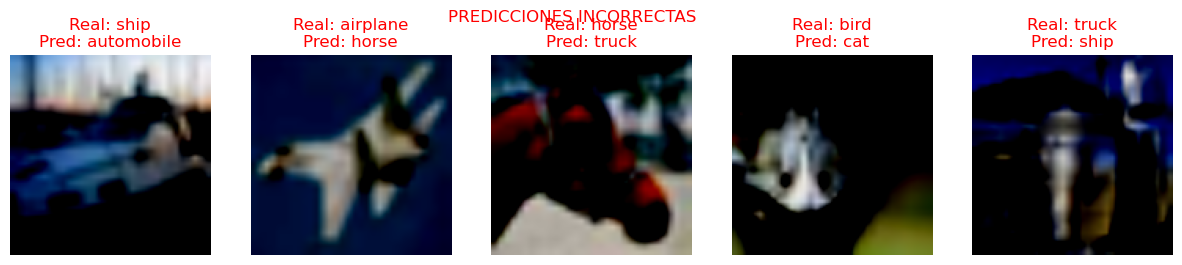

In [17]:

# --- Extraer imágenes y etiquetas del dataset ---
images = []
labels = []

for batch in test_ds:
    x_batch, y_batch = batch
    images.append(x_batch.numpy())  # convertir tensores a numpy
    labels.append(y_batch.numpy())

# Concatenar todos los batches
x_test_ds = np.concatenate(images, axis=0)
y_test_ds = np.concatenate(labels, axis=0).flatten().astype(int)  # 1D

# --- Predicciones ---
y_pred_ds = np.argmax(model.predict(test_ds), axis=1).astype(int)

# --- Índices correctos e incorrectos ---
correct_indices = np.where(y_pred_ds == y_test_ds)[0]
incorrect_indices = np.where(y_pred_ds != y_test_ds)[0]

# --- Mostrar 5 predicciones correctas ---
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    idx = correct_indices[i]
    axes[i].imshow(x_test_ds[idx])
    axes[i].set_title(f"Real: {class_names[y_test_ds[idx]]}\nPred: {class_names[y_pred_ds[idx]]}", color="green")
    axes[i].axis("off")
plt.suptitle("PREDICCIONES CORRECTAS", color="green")
plt.show()

# --- Mostrar 5 predicciones incorrectas ---
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    idx = incorrect_indices[i]
    axes[i].imshow(x_test_ds[idx])
    axes[i].set_title(f"Real: {class_names[y_test_ds[idx]]}\nPred: {class_names[y_pred_ds[idx]]}", color="red")
    axes[i].axis("off")
plt.suptitle("PREDICCIONES INCORRECTAS", color="red")
plt.show()


In [23]:
# FINE-TUNING - DESCONGELAR ÚLTIMAS CAPAS
# ======================================

# Descongelar las últimas 20 capas del modelo base

for layer in base_model.layers[-20:]:
    layer.trainable = True

# ESTO SE HACE SI EL MODELO BASE TIENE CAPAS DE: BatchNormalization (hay 7)
# Congelar todas las capas BatchNormalization para evitar inestabilidad

for layer in base_model.layers:
     if isinstance(layer, tf.keras.layers.BatchNormalization):
         layer.trainable = False

trainable = 0
frozen = 0
for layer in model.layers:
    if layer.trainable:
        trainable += 1
    else:
        frozen += 1
print(f"Capas entrenables:{trainable}")
print(f"Capas congeladas:{frozen}")

Capas entrenables:4
Capas congeladas:1


In [30]:
# =============================================
#  COMPILACIÓN Y ENTRENAMIENTO CON FINE-TUNING
# =============================================

# Importante para no cargarse el modelo anterior:
# Poner una tasa de aprendizaje muy baja
#   learning_rate = 0.0001


# Recompilar modelo con learning rate MUY BAJO
model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Early Stopping para Fine-Tuning
early_stop_fine = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1)

# Entrenamiento con Fine-Tuning
history_fine  = model.fit(
    train_ds, 
    epochs = 10,
    validation_data=(val_ds),                  
    callbacks=[early_stop], # Llamada para que pare
    verbose=1)

print("Entrenado!")



Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 343s 530ms/step - accuracy: 0.8537 - loss: 0.4276 - val_accuracy: 0.8607 - val_loss: 0.4105
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 310s 495ms/step - accuracy: 0.8624 - loss: 0.4133 - val_accuracy: 0.8694 - val_loss: 0.3941
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 295s 472ms/step - accuracy: 0.8690 - loss: 0.3863 - val_accuracy: 0.8742 - val_loss: 0.3785
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 521ms/step - accuracy: 0.8768 - loss: 0.3663 - val_accuracy: 0.8776 - val_loss: 0.3619
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 297s 474ms/step - accuracy: 0.8822 - loss: 0.3505 - val_accuracy: 0.8771 - val_loss: 0.3616
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 381s 610ms/step - accuracy: 0.8833 - loss: 0.3409 - val_accuracy: 0.8831 - val_loss: 0.3553
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 364s 582ms/step - accuracy: 0.8894 - loss: 0.3292 - val_accuracy: 0.8782 - val_loss: 0.3662
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 343s 549ms/step - accuracy: 0.8929 -

              precision    recall  f1-score   support

    airplane       0.11      0.12      0.11      1000
  automobile       0.10      0.10      0.10      1000
        bird       0.10      0.10      0.10      1000
         cat       0.10      0.11      0.11      1000
        deer       0.10      0.10      0.10      1000
         dog       0.09      0.08      0.09      1000
        frog       0.11      0.11      0.11      1000
       horse       0.08      0.08      0.08      1000
        ship       0.10      0.10      0.10      1000
       truck       0.09      0.09      0.09      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



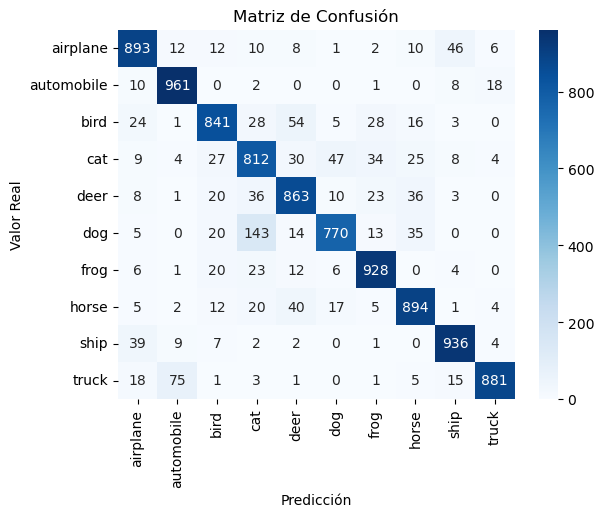

In [31]:
# Predecir probabilidades
y_pred_probs = model.predict(test_ds, verbose=0)

# Convertir a etiquetas usando argmax
y_pred = np.argmax(y_pred_probs, axis=1)

y_true_test = np.concatenate([y.numpy() for _, y in test_ds])

# Reporte de clasificación
from sklearn.metrics import classification_report
report = classification_report(y_val, y_pred, target_names=class_names)
print(report)

# =====================
#  Matriz de Confusión
# =====================

y_pred_probs = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_test = np.concatenate([y.numpy() for _, y in test_ds])

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

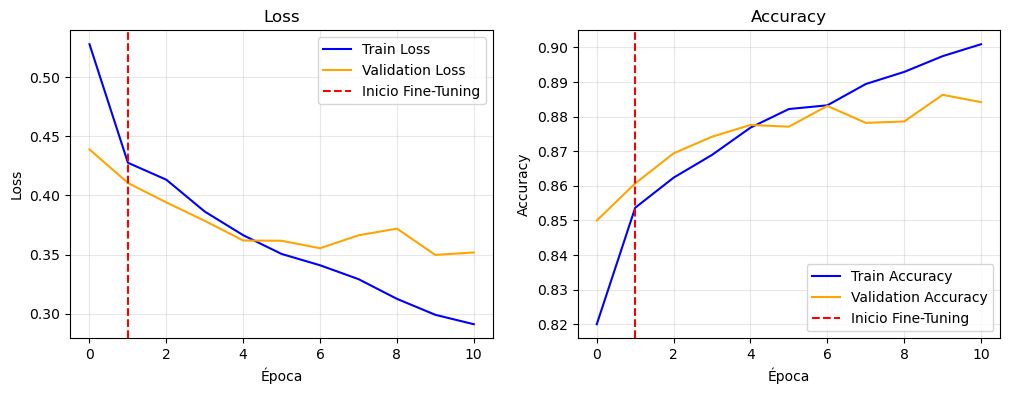

TRAIN:
Loss óptimo: 0.5278
Accuracy óptimo: 82.00%
Loss final: 0.5278
Accuracy final: 82.00%

VALIDATION:
Loss óptimo: 0.4389
Accuracy óptimo: 85.00%
Loss final: 0.4389
Accuracy final: 85.00%


In [32]:
# VISUALIZACIÓN DE CURVAS COMPLETAS
# =================================
# Combinar historiales de Feature Extraction + Fine-Tuning

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Calcular dónde empieza Fine-Tuning para la línea vertical

initial_epochs = len(history.history['loss'])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de Loss

axes[0].plot(loss, label='Train Loss', color='blue')
axes[0].plot(val_loss, label='Validation Loss', color='orange')
axes[0].axvline(x=initial_epochs, color='red', linestyle='--', label='Inicio Fine-Tuning')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de Accuracy

axes[1].plot(acc, label='Train Accuracy', color='blue')
axes[1].plot(val_acc, label='Validation Accuracy', color='orange')
axes[1].axvline(x=initial_epochs, color='red', linestyle='--', label='Inicio Fine-Tuning')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.show()

# Mostrar valores de entrenamiento

best_epoch = np.argmin(history.history['val_loss'])
print(f"TRAIN:")
print(f"Loss óptimo: {history.history['loss'][best_epoch]:.4f}")
print(f"Accuracy óptimo: {history.history['accuracy'][best_epoch]*100:.2f}%")
print(f"Loss final: {history.history['loss'][-1]:.4f}")
print(f"Accuracy final: {history.history['accuracy'][-1]*100:.2f}%")
print()
print(f"VALIDATION:")
print(f"Loss óptimo: {history.history['val_loss'][best_epoch]:.4f}")
print(f"Accuracy óptimo: {history.history['val_accuracy'][best_epoch]*100:.2f}%")
print(f"Loss final: {history.history['val_loss'][-1]:.4f}")
print(f"Accuracy final: {history.history['val_accuracy'][-1]*100:.2f}%")

157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 463ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8726716..0.98026955].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.921201].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9759804..0.9675245].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70637256..0.8259804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93235296..0.7019608].


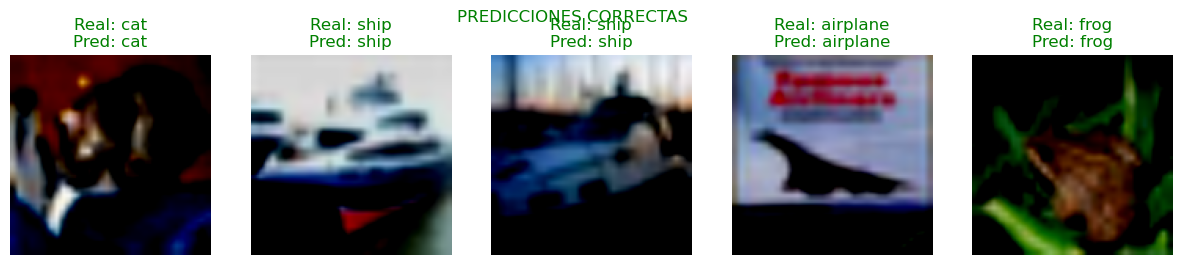

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77340686..0.67499995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96360296..0.6128676].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90821075].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95870095..0.9530637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8715687].


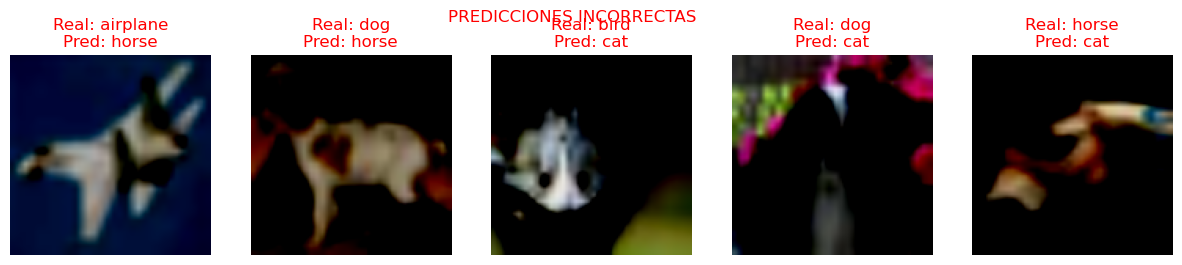

In [33]:
# --- Extraer imágenes y etiquetas del dataset ---
images = []
labels = []

for batch in test_ds:
    x_batch, y_batch = batch
    images.append(x_batch.numpy())  # convertir tensores a numpy
    labels.append(y_batch.numpy())

# Concatenar todos los batches
x_test_ds = np.concatenate(images, axis=0)
y_test_ds = np.concatenate(labels, axis=0).flatten().astype(int)  # 1D

# --- Predicciones ---
y_pred_ds = np.argmax(model.predict(test_ds), axis=1).astype(int)

# --- Índices correctos e incorrectos ---
correct_indices = np.where(y_pred_ds == y_test_ds)[0]
incorrect_indices = np.where(y_pred_ds != y_test_ds)[0]

# --- Mostrar 5 predicciones correctas ---
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    idx = correct_indices[i]
    axes[i].imshow(x_test_ds[idx])
    axes[i].set_title(f"Real: {class_names[y_test_ds[idx]]}\nPred: {class_names[y_pred_ds[idx]]}", color="green")
    axes[i].axis("off")
plt.suptitle("PREDICCIONES CORRECTAS", color="green")
plt.show()

# --- Mostrar 5 predicciones incorrectas ---
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    idx = incorrect_indices[i]
    axes[i].imshow(x_test_ds[idx])
    axes[i].set_title(f"Real: {class_names[y_test_ds[idx]]}\nPred: {class_names[y_pred_ds[idx]]}", color="red")
    axes[i].axis("off")
plt.suptitle("PREDICCIONES INCORRECTAS", color="red")
plt.show()